# Tutorial

Key Features of Simulator:
- Stochastic loading
- Supports simulation of atom loss channels
  - Move failure
  - Atom ejection
  - Atom loss from heating/limited lifetime
- Supports rearrangement through specific moves and AOD commands

In [ ]:
## This code is used to test the new DDS feature of the AWG card from Spectrum Instrumentation.
## It is to be used together with PPLB's Rearrangement Simulator and Spectrum's DDS firmware.

# imports
from source.animation import *
from source.utils import *
from source.benchmarking import *


ModuleNotFoundError: No module named 'source'

## Stochastic Tweezer Loading

c:\Users\berni\anaconda3\envs\awg_test\lib\site-packages\numba\core\dispatcher.py:289: UserWarning: Numba extension module 'numba_dppy.numpy_usm_shared' failed to load due to 'ImportError(DLL load failed while importing _sycl_context: The specified module could not be found.)'.
  entrypoints.init_all()
c:\Users\berni\anaconda3\envs\awg_test\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'size' of function 'random_loading'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "source\utils\core.py", line 412:
@jit
def random_loading(size, probability):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Initial Configuration:


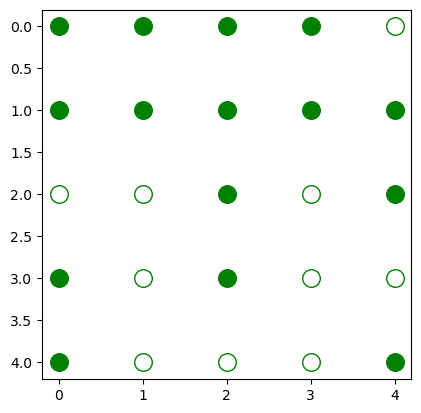

Target Configuration:


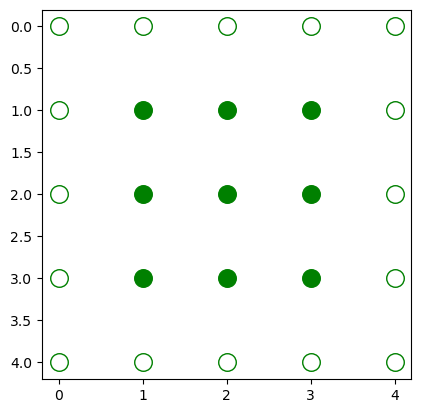

In [ ]:
## Loading a random initial configurations of atoms ##

# specifying parameters
load_prob = 0.5 # float; the probability that an individual site will be loaded
array_length = 5 # int; number of rows (or cols) of the square array

params = PhysicalParams(loading_prob = load_prob, array_len=array_length)

# loading random configuration
init_config = random_loading([array_length, array_length], load_prob)
init_config = np.array([[1, 1, 1, 1, 0],[1, 1, 1, 1, 1],[0, 0, 1, 0, 1],[1, 0, 1, 0, 0],[1, 0, 0, 0, 1]])
# choosing a target configuration for rearrangement
target_config = generate_target_config([array_length, array_length], Configurations.MIDDLE_FILL)

print("Initial Configuration:")
fig_atom_arrays(init_config)

print("Target Configuration:")
fig_atom_arrays(target_config)

## Rearranging Initial Configuration

Rearrangement Time: 0.35 ms
Final Configuration:


<Figure size 640x480 with 0 Axes>

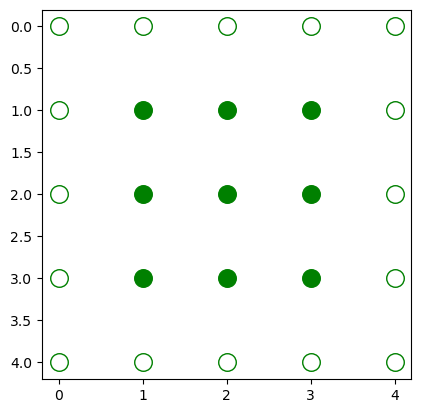

In [ ]:
## Run a rearrangement algorithm on the initial array ##

algo = Bluelab()

#final_config, move_list, success_flag = algo.get_moves(init_config, target_config, do_ejection = True)
final_config, move_list, success_flag, what = algo.get_moves(init_config, target_config, do_ejection = True)

params = PhysicalParams(pickup_fail_rate=0.01, putdown_fail_rate=0.01, lifetime = 30)

#t_total = make_gif_nikhil_new(init_config, move_list, params, savename = 'benchmarking_balance')
t_total = make_gif(init_config, move_list, params, savename = 'benchmarking_balance', duration = 3)
print("Rearrangement Time: {:.2f} ms".format(t_total*1e3))

print("Final Configuration:")
fig_atom_arrays(final_config)

#print('Failed')

In [ ]:
## Display the result of the rearrangement algorithm
print('What:', what)
print('Moves:', move_list)
print('Success:', success_flag)
print('Final Config:', final_config)

What: [2, 2, 3]
Moves: [[<source.utils.move_utils.Move object at 0x000001DFADF08DC0>], [<source.utils.move_utils.Move object at 0x000001DFADF08250>, <source.utils.move_utils.Move object at 0x000001DFADF08700>], [<source.utils.move_utils.Move object at 0x000001DFADF086D0>, <source.utils.move_utils.Move object at 0x000001DFADF08D90>], [<source.utils.move_utils.Move object at 0x000001DFADF08D60>, <source.utils.move_utils.Move object at 0x000001DFADF08D30>], [<source.utils.move_utils.Move object at 0x000001DFADF08730>, <source.utils.move_utils.Move object at 0x000001DFADF08760>], [<source.utils.move_utils.Move object at 0x000001DFADF08790>], [<source.utils.move_utils.Move object at 0x000001DFADF08FD0>, <source.utils.move_utils.Move object at 0x000001DFADF08CA0>, <source.utils.move_utils.Move object at 0x000001DFADF08CD0>, <source.utils.move_utils.Move object at 0x000001DFADF08550>]]
Success: True
Final Config: [[0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]


In [ ]:
## As a toy model, we use a 5 * 5 array for now.
array_length = 5

## Assign RF frequency to each grid point ##
## RF frequency 78 MHz to 82 MHz for both channels
rf_H_static = np.linspace(77, 83, array_length + 2)
rf_V_static = np.linspace(77, 83, array_length + 2)
## plus 2 terms in the end
rf_H_static = np.roll(rf_H_static, -1)
rf_V_static = np.roll(rf_V_static, -1)
rf_H_static

array([78., 79., 80., 81., 82., 83., 77.])

In [ ]:
def generate_AOD_cmds(matrix, move_seq):
    row_num = len(matrix)
    col_num = len(matrix[0])
    horiz_AOD_cmds = np.zeros([row_num])
    vert_AOD_cmds = np.zeros([col_num])

    # Generate AOD commands for a given row and column number
    for move in move_seq:
        # Chnage the status of vertical AOD commands
        if move.from_row > move.to_row:
            vert_AOD_cmds[move.from_row] = 3
        elif move.from_row < move.to_row:
            vert_AOD_cmds[move.from_row] = 2
        else:
            vert_AOD_cmds[move.from_row] = 1

        # Change the status of horizontal AOD commands
        if move.from_col > move.to_col:
            horiz_AOD_cmds[move.from_col] = 3
        elif move.from_col < move.to_col:
            horiz_AOD_cmds[move.from_col] = 2
        else:
            horiz_AOD_cmds[move.from_col] = 1

    return horiz_AOD_cmds, vert_AOD_cmds

print("horizontal AOD commands / vertical AOD commands")

for i in range(len(move_list)):
    print(generate_AOD_cmds(init_config, move_list[i]))

    '''
    ## Print the actions for each DDS core based on the cmds
    horiz_AOD_cmds, vert_AOD_cmds = generate_AOD_cmds(init_config, move_list[i])

    ## Loop through the horizontal DDS cores
    for cmd in horiz_AOD_cmds:
        if cmd == 0:
            print('AOD Turned Off')
        elif cmd == 1:
            print('AOD Turned On')
        elif cmd == 2:
            startRF = rf_H_static[move_list[i][0].from_col]
            endRF = rf_H_static[move_list[i][0].to_col]
            print('AOD Ramp Up from {}MHz to {}MHz'.format(startRF, endRF))
        elif cmd == 3:
            print('AOD Ramp Down')
            startRF = rf_H_static[move_list[i][0].from_col]
            endRF = rf_H_static[move_list[i][0].to_col]
            print('AOD Ramp Down from {}MHz to {}MHz'.format(startRF, endRF))

    for cmd in vert_AOD_cmds:
        if cmd == 0:
            print('AOD Turned Off')
        elif cmd == 1:
            print('AOD Turned On')
        elif cmd == 2:
            startRF = rf_V_static[move_list[i][0].from_row]
            endRF = rf_V_static[move_list[i][0].to_row]
            print('AOD Ramp Up from {}MHz to {}MHz'.format(startRF, endRF))
        elif cmd == 3:
            startRF = rf_V_static[move_list[i][0].from_row]
            endRF = rf_V_static[move_list[i][0].to_row]
            print('AOD Ramp Down from {}MHz to {}MHz'.format(startRF, endRF))
    '''

horizontal AOD commands / vertical AOD commands
(array([1., 0., 0., 0., 0.]), array([0., 0., 0., 3., 0.]))
(array([1., 0., 0., 0., 1.]), array([0., 0., 0., 0., 3.]))
(array([2., 0., 0., 0., 3.]), array([0., 0., 1., 0., 0.]))
(array([2., 0., 0., 0., 3.]), array([0., 0., 0., 1., 0.]))
(array([3., 0., 0., 0., 0.]), array([1., 1., 0., 0., 0.]))
(array([0., 0., 0., 0., 1.]), array([0., 3., 0., 0., 0.]))
(array([0., 1., 1., 1., 1.]), array([3., 0., 0., 0., 0.]))


In [ ]:
## In this code, we only use linear frequency ramps to move the AOD tweezers. The entire sequency is slowed down to 30 second to record a video on the Thorcam.
## In future, we need to engineer a "minimum jerk" trajectory for coherent transport of atoms. Such curves may be approximated by a number of linear freq ramps.
## Also, during pick-up and put-down, it might be preferable to gradually increase the amplitude instead of using a constant value, as is done in the following code.

## Write the DDS cmds to the AWG card

import spcm
from spcm import units

card : spcm.Card #Init card
with spcm.Card('/dev/spcm0') as card:                         # if you want to open a specific card

    # setup card for DDS
    card.card_mode(spcm.SPC_REP_STD_DDS)

    # Setup the card
    channels = spcm.Channels(card) # Using other channels as output (can also specify channel)
    channels.enable(True)
    channels.output_load(50 * units.ohm) # Fixed param
    channels.amp(2.0 * units.V) # Specific to two cards in Bernien lab (may check other model)
    card.write_setup()

    # Setup DDS
    dds = spcm.DDS(card, channels=channels)
    dds.reset() # Not necessary, sometime helpful to stablize

    ## Switch groups of cores to other channels
    ## Wire core 0-4 to ch0 and core 8-11 + 20 to ch1 (because 5x5 array)
    # 8-11 for every 20x20 card
    dds.cores_on_channel(1, spcm.SPCM_DDS_CORE8,  spcm.SPCM_DDS_CORE9,  spcm.SPCM_DDS_CORE10, spcm.SPCM_DDS_CORE11, spcm.SPCM_DDS_CORE20) #
    horiz_cores = np.array([0, 1, 2, 3, 4])
    vert_cores = np.array([8, 9, 10, 11, 20])
    dds.cores_on
    # If we want to generate 1D, we could simply use CORE 20 for channel 1

    ## Max number of cores
    num_core = 5
    RF_spacing = 1 * units.MHz

    ## Initialize the internal timer
    dds.trg_src(spcm.SPCM_DDS_TRG_SRC_TIMER)

    # For slow ramps only change the value every 1000 steps; subject to the time resolution, tweezer 6.4us
    dds.freq_ramp_stepsize(1000)
    dds.amp_ramp_stepsize(1000)

###### General part ########
### Wrap the duplicate commands part into atommovr
    for i in range(len(move_list)):

    ## Generate actions for each DDS core based on the cmds
        for core in dds:
            core.amp(0 * units.percent)
            core.freq_slope(0)
            core.phase(0 * units.degrees)
            # Use dds.reset()

        horiz_AOD_cmds, vert_AOD_cmds = generate_AOD_cmds(init_config, move_list[i])
        dds.trg_src(spcm.SPCM_DDS_TRG_SRC_TIMER)#Might be redundant

        # STEP 0 - Initialize frequencies
        period_s = 1 * units.s
        dds.trg_timer(period_s)

        active_horiz_cores = horiz_cores[np.where(horiz_AOD_cmds > 0)]
        for core_num in active_horiz_cores:
            dds[core_num].amp(20 * units.percent) # Arbitrary try
            dds[core_num].freq(rf_H_static[np.where(core_num == horiz_cores)] * units.MHz)

        active_vert_cores = vert_cores[np.where(vert_AOD_cmds > 0)]
        for core_num in active_vert_cores:
            dds[core_num].amp(20 * units.percent)
            dds[core_num].freq(rf_V_static[np.where(core_num == vert_cores)] * units.MHz)

        dds.exec_at_trg()
        dds.write_to_card()

        # STEP 1 - Start the ramp
        ## Make it slowly to record
        period_s = 28 * units.s # Should be 28 ms
        dds.trg_timer(period_s)

        active_horiz_rampup = horiz_cores[np.where(horiz_AOD_cmds == 2)]
        for core_num in active_horiz_rampup:
            dds[core_num].freq_slope(RF_spacing / period_s)

        active_horiz_rampdown = horiz_cores[np.where(horiz_AOD_cmds == 3)]
        for core_num in active_horiz_rampdown:
            dds[core_num].freq_slope(-RF_spacing / period_s)

        active_vert_rampup = vert_cores[np.where(vert_AOD_cmds == 2)]
        for core_num in active_vert_rampup:
            dds[core_num].freq_slope(RF_spacing / period_s)

        active_vert_rampdown = vert_cores[np.where(vert_AOD_cmds == 3)]
        for core_num in active_vert_rampdown:
            dds[core_num].freq_slope(-RF_spacing / period_s)

        dds.exec_at_trg()
        dds.write_to_card()
        #print(active_horiz_rampup, active_horiz_rampdown, active_vert_rampup, active_vert_rampdown)

        # STEP 2 - Stop the ramp
        period_s = 1 * units.s
        dds.trg_timer(period_s)

        for core_num in active_horiz_rampup:
            dds[core_num].freq_slope(0)
            dds[core_num].freq(rf_H_static[np.where(core_num == horiz_cores)] * units.MHz + RF_spacing)

        for core_num in active_horiz_rampdown:
            dds[core_num].freq_slope(0)
            dds[core_num].freq(rf_H_static[np.where(core_num == horiz_cores)] * units.MHz - RF_spacing)

        for core_num in active_vert_rampup:
            dds[core_num].freq_slope(0)
            dds[core_num].freq(rf_V_static[np.where(core_num == vert_cores)] * units.MHz + RF_spacing)

        for core_num in active_vert_rampdown:
            dds[core_num].freq_slope(0)
            dds[core_num].freq(rf_V_static[np.where(core_num == vert_cores)] * units.MHz - RF_spacing)

        dds.exec_at_trg()
        dds.write_to_card()
    dds.write_to_card() # Can write only once
    # Start command including enable of trigger engine
    card.start(spcm.M2CMD_CARD_ENABLETRIGGER, spcm.M2CMD_CARD_FORCETRIGGER)
    input("Press Enter to Exit")

######## General part###############